In [349]:
# Данный python-скрипт имитирует запрос к БД
# Напишите ваш SQL-запрос в query и запустите данный python-скрипт для получения результата
# Перед запуском скрипта установите библиотеку duckdb

# Установка библиотеки duckdb
# pip install duckdb duckdb-engine

# Импорт библиотек
import pandas as pd
import duckdb

# Задание таблиц БД
users = pd.read_csv('users.csv')
course_users = pd.read_csv('course_users.csv')
courses = pd.read_csv('courses.csv')
course_types = pd.read_csv('course_types.csv')
lessons = pd.read_csv('lessons.csv')
subjects = pd.read_csv('subjects.csv')
cities = pd.read_csv('cities.csv')
homework_done = pd.read_csv('homework_done.csv')
homework = pd.read_csv('homework.csv')
homework_lessons = pd.read_csv('homework_lessons.csv')
user_roles = pd.read_csv('user_roles.csv') 

In [ ]:
import numpy as np
new_q = """
WITH hw_per_course AS( -- Таблица с данными о сделанных и существующих дз по курсам
    SELECT c.id course_id,
    c.name course_name, 
    c.subject_id subject_id, 
    c.starts_at starts_at,
    hw_d.id done_hw,
    hw.id total_hw,
    hw_d.user_id user_id,
    FROM courses c 
    INNER JOIN
    lessons l on l.course_id = c.id 
    INNER JOIN
    homework_lessons hw_l on l.id = hw_l.homework_id 
    INNER JOIN
    homework_done hw_d on hw_l.homework_id = hw_d.homework_id
    INNER JOIN
    homework hw on hw_l.homework_id = hw.id
), hw_per_student AS( -- Таблица с данными о сделанных и существующих дз по студентам
    SELECT user_id, course_name, subject_id, course_id, starts_at, COUNT(done_hw) hw_completed, COUNT(total_hw) hw_opened FROM hw_per_course
    GROUP BY 1, 2, 3, 4, 5
), monthly_active AS (
    -- Число продлений
    SELECT cu.user_id,
           cu.course_id,
           DATE_TRUNC('month', cu.created_at::TIMESTAMP) AS month_period,
           SUM(CASE WHEN cu.active = 1 THEN 1 ELSE 0 END) AS active_months
    FROM course_users cu
    GROUP BY cu.user_id, cu.course_id, month_period
)
SELECT 
DISTINCT hw_stud.course_id,  
        hw_stud.course_name, 
        s.name, 
        s.project,  
        hw_stud.starts_at, 
        hw_stud.user_id, 
        u.last_name, 
        cities.name city, 
        cu.active, 
        cu.created_at personal_started_at, 
        SUM(CASE WHEN ma.active_months > 0 THEN 1 ELSE 0 END) OVER (PARTITION BY hw_stud.user_id, hw_stud.course_id ORDER BY ma.month_period ROWS UNBOUNDED PRECEDING) AS total_month,
        hw_stud.hw_completed,
FROM hw_per_student hw_stud
INNER JOIN 
    users u on u.id = hw_stud.user_id 
INNER JOIN 
    cities ON cities.id = u.city_id
INNER JOIN 
    subjects s ON s.id = hw_stud.subject_id 
INNER JOIN 
    course_users cu ON cu.user_id = hw_stud.user_id 
INNER JOIN 
    user_roles ur ON u.user_role_id = ur.id
INNER JOIN 
    courses on courses.id = hw_stud.course_id
INNER JOIN 
    monthly_active ma ON 
    hw_stud.user_id = ma.user_id AND 
    hw_stud.course_id = ma.course_id
WHERE ur.name = 'student'
"""
df_result = duckdb.query(new_q).to_df()

#df_result['total_length'].fillna('0', inplace=True) 
#df_result['total_length'] = df_result['total_length'].astype('float').round(0)
df_result['personal_started_at'] = pd.to_datetime(df_result['personal_started_at'])
df_result['starts_at'] = pd.to_datetime(df_result['starts_at'])

time_diff = df_result['personal_started_at'] - df_result['starts_at']
# Разделение на волны
conditions = [
    (time_diff <= pd.Timedelta("0 day")),
    (time_diff > pd.Timedelta("0 day")) & (time_diff <= pd.Timedelta("7 day")),
    (time_diff > pd.Timedelta("7 day")) & (time_diff <= pd.Timedelta("14 day")),
    (time_diff > pd.Timedelta("14 day")) & (time_diff <= pd.Timedelta("21 day")),
    (time_diff > pd.Timedelta("21 day")) & (time_diff <= pd.Timedelta("28 day")),
    (time_diff > pd.Timedelta("28 day"))
]
wave_values = [0, 1, 2, 3, 4, 5]
df_result['wave'] = np.select(conditions, wave_values)

# Подсчёт продлений студента, т.е. число открытых месяцев курса
#df_result['active'] = df_result['active'].astype(int)
#df_result['month_started'] = df_result['personal_started_at'].dt.to_period('M')
#df_result['curr_month'] = (
#    df_result
#    .groupby(['user_id', 'course_id', 'month_started'])['active']
#    .transform(lambda x: x.cumsum())
#)
display(df_result)

,course_id,course_name,name,project,starts_at,user_id,last_name,city,active,personal_started_at,total_month,hw_completed,wave
0,16,Годовой 2к25 стандарт,Обществознание,ЕГЭ,2024-09-16,10001,Markova,Самара,0,2024-07-25 18:04:19,7.0,1,0
1,16,Годовой 2к25 стандарт,Обществознание,ЕГЭ,2024-09-16,10001,Markova,Самара,1,2024-07-25 18:04:20,5.0,1,0
2,16,Годовой 2к25 стандарт,Обществознание,ЕГЭ,2024-09-16,10001,Markova,Самара,1,2024-07-25 18:04:20,4.0,1,0
3,16,Годовой 2к25 стандарт,Обществознание,ЕГЭ,2024-09-16,10001,Markova,Самара,0,2024-07-25 18:04:20,6.0,1,0
4,16,Годовой 2к25 стандарт,Обществознание,ЕГЭ,2024-09-16,10001,Markova,Самара,1,2024-08-05 12:14:09,3.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20481,19,Годовой 2к25 стандарт,Русский,ЕГЭ,2024-09-21,33998,Грушева,Сургут,1,2024-10-11 17:29:03,2.0,1,3
20482,19,Годовой 2к25 стандарт,Русский,ЕГЭ,2024-09-21,33998,Грушева,Сургут,1,2024-10-11 17:29:03,3.0,1,3
20483,19,Годовой 2к25 стандарт,Русский,ЕГЭ,2024-09-21,33998,Грушева,Сургут,1,2024-11-03 14:43:47,1.0,1,5
20484,16,Годовой 2к25 стандарт,Обществознание,ЕГЭ,2024-09-16,33999,Катырева,Балашиха,1,2024-10-11 19:58:17,2.0,1,4


In [344]:
df_result.isna().sum()

course_id              0
course_name            0
name                   0
project                0
starts_at              0
user_id                0
last_name              0
city                   0
active                 0
personal_started_at    0
total_length           0
hw_completed           0
month_started          0
curr_month             0
wave                   0
dtype: int64

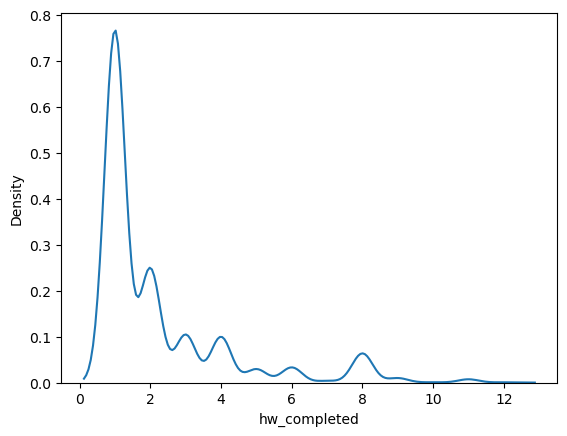

In [345]:
import seaborn as sns
sns.kdeplot(df_result['hw_completed']);

In [346]:
df_result['active'].value_counts(normalize=True)

1    0.83135
0    0.16865
Name: active, dtype: float64

In [347]:
df_result.to_csv("res.csv")

## Дальше вспомогательные, где я просто смотрел данные

In [370]:
new_que = """
WITH hw_per_course AS ( 
    -- Table with data on completed and existing homework by courses
    SELECT c.id AS course_id,
           c.name AS course_name, 
           c.subject_id AS subject_id, 
           c.starts_at AS starts_at,
           hw_d.id AS done_hw,
           hw.id AS total_hw,
           hw_d.user_id AS user_id
    FROM courses c 
    INNER JOIN lessons l ON l.course_id = c.id 
    INNER JOIN homework_lessons hw_l ON l.id = hw_l.homework_id 
    INNER JOIN homework_done hw_d ON hw_l.homework_id = hw_d.homework_id
    INNER JOIN homework hw ON hw_l.homework_id = hw.id
), hw_per_student AS (
    -- Table with data on completed and existing homework by students
    SELECT user_id, 
           course_name, 
           subject_id, 
           course_id, 
           starts_at, 
           COUNT(done_hw) AS hw_completed, 
           COUNT(total_hw) AS hw_opened 
    FROM hw_per_course
    GROUP BY user_id, course_name, subject_id, course_id, starts_at
), complete_months AS (
    -- Table with data on the length of the course in months
    SELECT cu.user_id, 
           cu.course_id AS course_id,
           COUNT(CASE WHEN cu.active = 1 THEN 1 END) AS active_months,
           COUNT(available_lessons) / SUM(c.lessons_in_month) AS total_months
    FROM course_users cu 
    INNER JOIN lessons l ON l.course_id = cu.course_id 
    INNER JOIN courses c ON c.id = cu.course_id 
    GROUP BY cu.user_id, cu.course_id
), monthly_active AS (
    -- Calculate the active months for each user and course
    SELECT cu.user_id,
           cu.course_id,
           DATE_TRUNC('month', cu.created_at::TIMESTAMP) AS month_period,
           SUM(CASE WHEN cu.active = 1 THEN 1 ELSE 0 END) AS active_months
    FROM course_users cu
    GROUP BY cu.user_id, cu.course_id, month_period
)
SELECT DISTINCT hw_stud.course_id,  
                hw_stud.course_name, 
                s.name, 
                s.project,  
                hw_stud.starts_at, 
                hw_stud.user_id, 
                u.last_name, 
                cities.name AS city, 
                cu.active, 
                cu.created_at AS personal_started_at, 
                cm.total_months AS total_length, 
                hw_stud.hw_completed,
                SUM(CASE WHEN ma.active_months > 0 THEN 1 ELSE 0 END) OVER (PARTITION BY hw_stud.user_id, hw_stud.course_id ORDER BY ma.month_period ROWS UNBOUNDED PRECEDING) AS total_month
FROM hw_per_student hw_stud
INNER JOIN users u ON u.id = hw_stud.user_id 
INNER JOIN cities ON cities.id = u.city_id
INNER JOIN subjects s ON s.id = hw_stud.subject_id 
INNER JOIN course_users cu ON cu.user_id = hw_stud.user_id 
INNER JOIN user_roles ur ON u.user_role_id = ur.id
INNER JOIN courses ON courses.id = hw_stud.course_id
INNER JOIN monthly_active ma ON hw_stud.user_id = ma.user_id AND hw_stud.course_id = ma.course_id
INNER JOIN complete_months cm ON hw_stud.user_id = cm.user_id AND hw_stud.course_id = cm.course_id
WHERE ur.name = 'student'
ORDER BY hw_stud.user_id, hw_stud.course_id, hw_stud.starts_at;
"""
df_result = duckdb.query(new_que).to_df()
#df_result['total_months'].fillna('0', inplace=True)
#df_result['total_months'] = df_result['total_months'].astype('float').round(0)
# Вывод результата
display(df_result)

,course_id,course_name,name,project,starts_at,user_id,last_name,city,active,personal_started_at,total_length,hw_completed,total_month
0,16,Годовой 2к25 стандарт,Обществознание,ЕГЭ,2024-09-16,10001,Markova,Самара,0,2024-07-25 18:04:20,0.100000,1,6.0
1,16,Годовой 2к25 стандарт,Обществознание,ЕГЭ,2024-09-16,10001,Markova,Самара,1,2024-07-25 18:04:20,0.100000,1,5.0
2,16,Годовой 2к25 стандарт,Обществознание,ЕГЭ,2024-09-16,10001,Markova,Самара,0,2024-07-25 18:04:19,0.100000,1,7.0
3,16,Годовой 2к25 стандарт,Обществознание,ЕГЭ,2024-09-16,10001,Markova,Самара,1,2024-08-05 12:14:09,0.100000,1,3.0
4,16,Годовой 2к25 стандарт,Обществознание,ЕГЭ,2024-09-16,10001,Markova,Самара,1,2024-11-03 14:43:47,0.100000,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20481,19,Годовой 2к25 стандарт,Русский,ЕГЭ,2024-09-21,33998,Грушева,Сургут,1,2024-10-11 17:29:03,0.111111,1,3.0
20482,19,Годовой 2к25 стандарт,Русский,ЕГЭ,2024-09-21,33998,Грушева,Сургут,1,2024-11-03 14:43:47,0.111111,1,1.0
20483,19,Годовой 2к25 стандарт,Русский,ЕГЭ,2024-09-21,33998,Грушева,Сургут,1,2024-10-11 17:29:03,0.111111,1,2.0
20484,16,Годовой 2к25 стандарт,Обществознание,ЕГЭ,2024-09-16,33999,Катырева,Балашиха,1,2024-10-11 19:58:17,0.100000,1,2.0


<Axes: xlabel='total_months', ylabel='Count'>

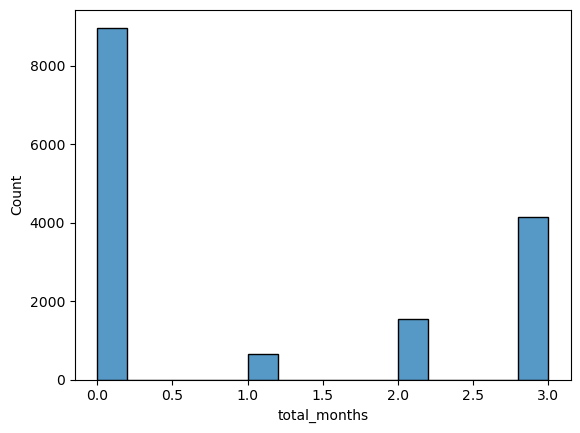

In [245]:
sns.histplot(df_result['total_months'])

In [285]:
new_que = """
SELECT 
* FROM users u
INNER JOIN
course_users cu on u.id = cu.user_id  
"""
df_result = duckdb.query(new_que).to_df()

# Вывод результата
display(len(df_result))

15347

In [123]:
new_que = """
WITH last_first_hw_per_user AS(
SELECT hw_d.user_id user_id, 
hw.created_at maxi,
hw.created_at mini 
FROM homework_done hw_d
INNER JOIN 
homework_lessons hw_l 
ON hw_d.homework_id = hw_l.id
INNER JOIN 
homework hw 
ON hw_d.homework_id = hw.id
--GROUP BY 1
)
SELECT * FROM last_first_hw_per_user
"""
df_result = duckdb.query(new_que).to_df()

# Вывод результата
display(df_result)

,user_id,maxi,mini
0,10001,2024-09-16 16:49:53,2024-09-16 16:49:53
1,10001,2024-09-15 13:08:27,2024-09-15 13:08:27
2,10001,2024-09-16 16:53:30,2024-09-16 16:53:30
3,10001,2024-09-18 14:56:34,2024-09-18 14:56:34
4,10001,2024-09-23 20:22:18,2024-09-23 20:22:18
...,...,...,...
45188,33993,2024-09-18 23:05:56,2024-09-18 23:05:56
45189,33994,2024-09-18 23:05:56,2024-09-18 23:05:56
45190,33997,2024-09-18 23:05:56,2024-09-18 23:05:56
45191,33998,2024-09-18 23:05:56,2024-09-18 23:05:56
